# Exercise 2 - Transformer-Based NLP Task
## Fake-News Detection

The objective of this exercise is to modify and fine-tune a Transformer model for the task of detecting **Fake News**.<br>

- <b>Group 3:</b> Cesar Laura, Ecker Annina, Dilly Julian
- <b>Use Case 6:</b> "Fake News Detection"
<br>
<br>
<div class="alert alert-block alert-info">
Note: Each of us worked on all tasks independently. We later discussed our findings and merged the best/most representative parts with eachother in one Notebook.
</div>

In [ ]:
#!pip install -r requirements.txt

In [1]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device")
else:
    device = torch.device("cpu")
    print("Using CPU device")

Using MPS device


In [161]:
import warnings
warnings.filterwarnings('ignore')

import re

from datasets import load_dataset, load_metric
import random

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import transformers
from transformers import pipeline, set_seed
from transformers import DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments, TrainerCallback
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification, EarlyStoppingCallback

from livelossplot import PlotLosses

from IPython.display import display, clear_output

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split

import torch
from torch.nn.functional import softmax


import textwrap

from collections import Counter

from datetime import datetime

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = list(set(stopwords.words('english')))
from string import punctuation
punctuation = list(punctuation)

from tqdm.notebook import tqdm

from datasets import Dataset


#_____________________________________________________

batch_size = 16
seed = 42

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/annina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
fake_df = pd.read_csv("fake.csv")
true_df = pd.read_csv("true.csv")

In [52]:
fake_df.head(5)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [60]:
#true_df.head(5)
fake_df.head(5)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [59]:
true_df.columns
#fake_df.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [58]:
#true_df.isna().sum()
fake_df.isna().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [62]:
def most_common(corpus, nb_words):
    articles = corpus.str.split()
    # Explanation of nested list comprehension:
    # Iterate through every article in articles
    # Iterate through every word in article (second for in loop)
    # Add word to the np.array if it is not a stopword (nltk)
    words = np.array([word for article in articles for word in article if word.lower() not in stopwords])
    counter = Counter(words)
    d = pd.DataFrame(counter, index=['occurences']).transpose().reset_index()
    d.columns = ['word', 'occurences']
    d = d.sort_values('occurences', ascending=False)
    return d[:nb_words]

In [65]:
most_common(true_df['text'], 10)

,word,occurences
113,said,72025
7,U.S.,38271
73,Trump,36461
162,would,31330
2,-,31059
136,said.,21582
1,(Reuters),21239
71,President,17112
79,also,15703
164,United,15030


In [66]:
most_common(fake_df['text'], 10)

,word,occurences
1,Trump,64844
90,would,23024
106,people,21266
304,said,21112
22,one,19037
0,Donald,16751
62,like,16314
596,Obama,15925
1061,Clinton,15528
40,President,15191


In [69]:
fake_df['text']

0        Donald Trump just couldn t wish all Americans ...
1        House Intelligence Committee Chairman Devin Nu...
2        On Friday, it was revealed that former Milwauk...
3        On Christmas day, Donald Trump announced that ...
4        Pope Francis used his annual Christmas Day mes...
                               ...                        
23476    21st Century Wire says As 21WIRE reported earl...
23477    21st Century Wire says It s a familiar theme. ...
23478    Patrick Henningsen  21st Century WireRemember ...
23479    21st Century Wire says Al Jazeera America will...
23480    21st Century Wire says As 21WIRE predicted in ...
Name: text, Length: 23481, dtype: object

In [70]:
true_df['text']

0        WASHINGTON (Reuters) - The head of a conservat...
1        WASHINGTON (Reuters) - Transgender people will...
2        WASHINGTON (Reuters) - The special counsel inv...
3        WASHINGTON (Reuters) - Trump campaign adviser ...
4        SEATTLE/WASHINGTON (Reuters) - President Donal...
                               ...                        
21412    BRUSSELS (Reuters) - NATO allies on Tuesday we...
21413    LONDON (Reuters) - LexisNexis, a provider of l...
21414    MINSK (Reuters) - In the shadow of disused Sov...
21415    MOSCOW (Reuters) - Vatican Secretary of State ...
21416    JAKARTA (Reuters) - Indonesia will buy 11 Sukh...
Name: text, Length: 21417, dtype: object

<br>
As we can see the format of the text in the <i>true</i>_df differs from the <i>fake</i>_df. Many (if not all) records follow the same structure, starting with a given city name, followed by <i>(Reuters)</i>. Hence we need to assimilate the true_df in order to be able to make comparisons between the two data frames.<br><br>

In [72]:
for i in range(0, len(true_df['text'])):
    try :
        # Search if CITY (Reuters) exist, if it does, shift the index
        # to 3 more spaces to accomodate the hyphen
        start = re.search('(Reuters)',true_df['text'][i][0:49]).end() + 3
    except:
        pass
    else:
        true_df['text'][i] = true_df['text'][i][start:]

In [73]:
true_df['text']

0         The head of a conservative Republican faction...
1         Transgender people will be allowed for the fi...
2         The special counsel investigation of links be...
3         Trump campaign adviser George Papadopoulos to...
4         President Donald Trump called on the U.S. Pos...
                               ...                        
21412     NATO allies on Tuesday welcomed President Don...
21413     LexisNexis, a provider of legal, regulatory a...
21414     In the shadow of disused Soviet-era factories...
21415     Vatican Secretary of State Cardinal Pietro Pa...
21416     Indonesia will buy 11 Sukhoi fighter jets wor...
Name: text, Length: 21417, dtype: object

In [74]:
# Next we check for duplicates
duplicate = true_df['text'].value_counts()[true_df['text'].value_counts()>1]
duplicate = duplicate.rename_axis('unique_values').reset_index(name='counts')
duplicate

,unique_values,counts
0,Highlights for U.S. President Donald Trump’s ...,8
1,Highlights for U.S. President Donald Trump’s ...,5
2,Highlights of the day for U.S. President Dona...,5
3,Highlights for U.S. President Donald Trump’s ...,3
4,Thailand on Wednesday marked the start of a l...,2
...,...,...
207,The EU executive launched an unprecedented pr...,2
208,U.S. President Donald Trump ramped up his fig...,2
209,Polish President Andrzej Duda has signed into...,2
210,The 193-member United Nations General Assembl...,2


In [6]:
true_df['text'].value_counts()[true_df['text'].value_counts()>1].sum() - 212

225

In [7]:
true_df = true_df.drop_duplicates(subset=['text'], ignore_index=True)

In [8]:
true_df.shape

(21192, 4)

In [9]:
true_df['article'] = true_df['title'] + '.' + true_df['text']

In [10]:
true_df = true_df.drop(['title', 'text'], axis=1)

In [11]:
true_df

,subject,date,article
0,politicsNews,"December 31, 2017","As U.S. budget fight looms, Republicans flip t..."
1,politicsNews,"December 29, 2017",U.S. military to accept transgender recruits o...
2,politicsNews,"December 31, 2017",Senior U.S. Republican senator: 'Let Mr. Muell...
3,politicsNews,"December 30, 2017",FBI Russia probe helped by Australian diplomat...
4,politicsNews,"December 29, 2017",Trump wants Postal Service to charge 'much mor...
...,...,...,...
21187,worldnews,"August 22, 2017",'Fully committed' NATO backs new U.S. approach...
21188,worldnews,"August 22, 2017",LexisNexis withdrew two products from Chinese ...
21189,worldnews,"August 22, 2017",Minsk cultural hub becomes haven from authorit...
21190,worldnews,"August 22, 2017",Vatican upbeat on possibility of Pope Francis ...


In [12]:
# We need to change the date format into a uniform format
true_df['date_len'] = [len(x) for x in true_df['date']]
print(true_df['date_len'].value_counts())
true_df = true_df.drop(['date_len'], axis=1)

date_len
17    6262
18    5703
19    2495
14    2010
16    1699
15    1616
13    1183
12     224
Name: count, dtype: int64


In [13]:
dates = []
for x in true_df['date']:
    date = datetime.strptime(x,'%B %d, %Y ')
    dates.append(date)
true_df['date'] = dates

true_df

,subject,date,article
0,politicsNews,2017-12-31,"As U.S. budget fight looms, Republicans flip t..."
1,politicsNews,2017-12-29,U.S. military to accept transgender recruits o...
2,politicsNews,2017-12-31,Senior U.S. Republican senator: 'Let Mr. Muell...
3,politicsNews,2017-12-30,FBI Russia probe helped by Australian diplomat...
4,politicsNews,2017-12-29,Trump wants Postal Service to charge 'much mor...
...,...,...,...
21187,worldnews,2017-08-22,'Fully committed' NATO backs new U.S. approach...
21188,worldnews,2017-08-22,LexisNexis withdrew two products from Chinese ...
21189,worldnews,2017-08-22,Minsk cultural hub becomes haven from authorit...
21190,worldnews,2017-08-22,Vatican upbeat on possibility of Pope Francis ...


In [14]:
# Next we create a truth-label to flag the article as verified aka true
true_df['label'] = 1
true_df

,subject,date,article,label
0,politicsNews,2017-12-31,"As U.S. budget fight looms, Republicans flip t...",1
1,politicsNews,2017-12-29,U.S. military to accept transgender recruits o...,1
2,politicsNews,2017-12-31,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,politicsNews,2017-12-30,FBI Russia probe helped by Australian diplomat...,1
4,politicsNews,2017-12-29,Trump wants Postal Service to charge 'much mor...,1
...,...,...,...,...
21187,worldnews,2017-08-22,'Fully committed' NATO backs new U.S. approach...,1
21188,worldnews,2017-08-22,LexisNexis withdrew two products from Chinese ...,1
21189,worldnews,2017-08-22,Minsk cultural hub becomes haven from authorit...,1
21190,worldnews,2017-08-22,Vatican upbeat on possibility of Pope Francis ...,1


<hr>

In [15]:
# Next we finish the preprocessing by cleaning the fake_df data and do nearly the same checks as in true_df

duplicate = fake_df['text'].value_counts()[fake_df['text'].value_counts()>1]
duplicate = duplicate.rename_axis('unique_values').reset_index(name='counts')
duplicate

,unique_values,counts
0,,626
1,Things didn t go as well as Nicholle had hoped...,4
2,"On September 15, Hillary apparently held a r...",4
3,AP News The regulars amble in before dawn and...,4
4,,4
...,...,...
4923,Shawn Helton 21st Century WireOrlando s Puls...,2
4924,Just when you thought the 2014 election result...,2
4925,This is why we cannot do deals with Democrats ...,2
4926,21st Century Wire says It s called Tykables...,2


In [16]:
fake_df['text'].value_counts()[fake_df['text'].value_counts()>1].sum() - 4927 - 626

5401

In [17]:
# We have 626 blank records, and 4928 records are duplicated.
# Now we write those title-only records into a new variable and then drop it from the fake_df
blank = fake_df.loc[fake_df["text"] == duplicate["unique_values"][0]]
blank

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"
...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"


In [18]:
fake_df = fake_df.drop(blank.index)

In [19]:
fake_df = fake_df.drop_duplicates(subset=['text'], ignore_index=True)
fake_df

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
17449,The White House and The Theatrics of ‘Gun Cont...,21st Century Wire says All the world s a stage...,US_News,"January 7, 2016"
17450,Activists or Terrorists? How Media Controls an...,Randy Johnson 21st Century WireThe majority ...,US_News,"January 7, 2016"
17451,"BOILER ROOM – No Surrender, No Retreat, Heads ...",Tune in to the Alternate Current Radio Network...,US_News,"January 6, 2016"
17452,Federal Showdown Looms in Oregon After BLM Abu...,21st Century Wire says A new front has just op...,US_News,"January 4, 2016"


In [20]:
fake_df['article'] = fake_df['title'] + '.' + fake_df['text']

In [21]:
fake_df = fake_df.drop(['title', 'text'], axis=1)

In [22]:
fake_df['date_len'] = [len(x) for x in fake_df['date']]
print(fake_df['date_len'].value_counts())

date_len
12     6470
11     2474
16     2020
13     1722
17     1634
14     1622
15     1020
18      451
9        35
145       1
88        1
149       1
74        1
66        1
120       1
Name: count, dtype: int64


In [23]:
bad_date = fake_df.loc[fake_df["date_len"] > 18]
fake_df = fake_df.drop(index=bad_date.index)

In [24]:
dates = []
for x in fake_df['date']:
    try:
        date = datetime.strptime(x, '%B %d, %Y')
    except ValueError:
        try:
            date = datetime.strptime(x, '%d-%b-%y')
        except ValueError:
            date = datetime.strptime(x, '%b %d, %Y')
    dates.append(date)
fake_df['date'] = dates

In [25]:
fake_df['date'].nunique

<bound method IndexOpsMixin.nunique of 0       2017-12-31
1       2017-12-31
2       2017-12-30
3       2017-12-29
4       2017-12-25
           ...    
17449   2016-01-07
17450   2016-01-07
17451   2016-01-06
17452   2016-01-04
17453   2016-01-02
Name: date, Length: 17448, dtype: datetime64[ns]>

In [26]:
fake_df['label'] = 0
fake_df = fake_df.drop(['date_len'], axis=1)
fake_df

,subject,date,article,label
0,News,2017-12-31,Donald Trump Sends Out Embarrassing New Year’...,0
1,News,2017-12-31,Drunk Bragging Trump Staffer Started Russian ...,0
2,News,2017-12-30,Sheriff David Clarke Becomes An Internet Joke...,0
3,News,2017-12-29,Trump Is So Obsessed He Even Has Obama’s Name...,0
4,News,2017-12-25,Pope Francis Just Called Out Donald Trump Dur...,0
...,...,...,...,...
17449,US_News,2016-01-07,The White House and The Theatrics of ‘Gun Cont...,0
17450,US_News,2016-01-07,Activists or Terrorists? How Media Controls an...,0
17451,US_News,2016-01-06,"BOILER ROOM – No Surrender, No Retreat, Heads ...",0
17452,US_News,2016-01-04,Federal Showdown Looms in Oregon After BLM Abu...,0


<hr>

In [31]:
concat_data = pd.concat([true_df, fake_df])
concat_data = concat_data.reset_index(drop=True)
concat_data

,subject,date,article,label
0,politicsNews,2017-12-31,"As U.S. budget fight looms, Republicans flip t...",1
1,politicsNews,2017-12-29,U.S. military to accept transgender recruits o...,1
2,politicsNews,2017-12-31,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,politicsNews,2017-12-30,FBI Russia probe helped by Australian diplomat...,1
4,politicsNews,2017-12-29,Trump wants Postal Service to charge 'much mor...,1
...,...,...,...,...
38635,US_News,2016-01-07,The White House and The Theatrics of ‘Gun Cont...,0
38636,US_News,2016-01-07,Activists or Terrorists? How Media Controls an...,0
38637,US_News,2016-01-06,"BOILER ROOM – No Surrender, No Retreat, Heads ...",0
38638,US_News,2016-01-04,Federal Showdown Looms in Oregon After BLM Abu...,0


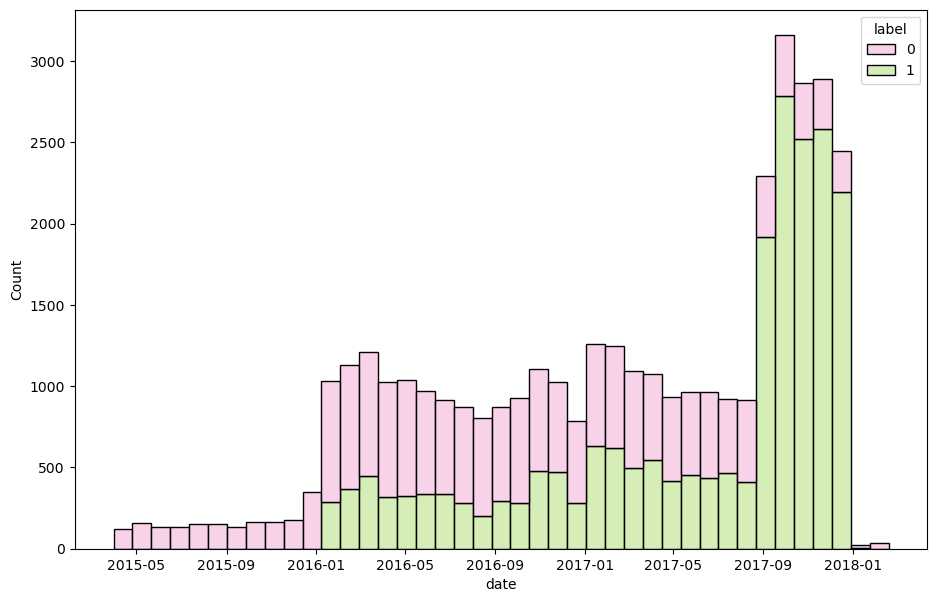

In [32]:
fig, hist = plt.subplots(figsize = (11,7))
hist = sns.histplot(data=concat_data, x = 'date', hue="label", palette='PiYG', multiple="stack")

<br>
The histplot shows a broader distribution of verfied as well as fake articles. Fake articles start at around 2015, where true articles start at the beginning of 2016. A significant increase of valid articles are in the timespan between September 2017 to December/January 2018.
<br><br>

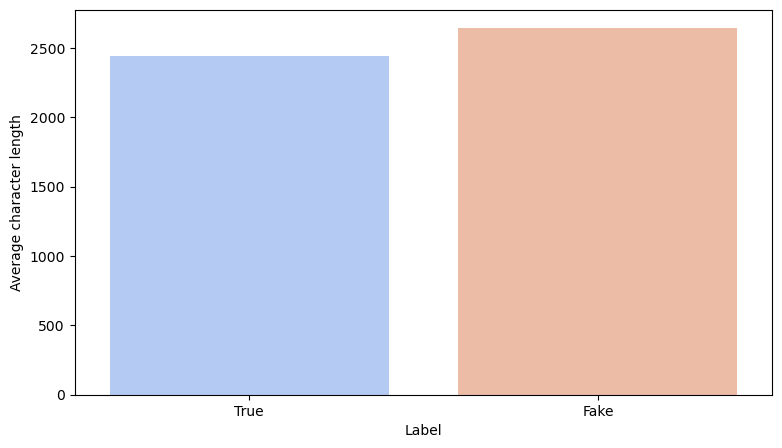

In [34]:
av_t = concat_data[concat_data['label'] == 1]['article'].apply(lambda x: len(x)).mean()
av_f = concat_data[concat_data['label'] == 0]['article'].apply(lambda x: len(x)).mean()
av = pd.DataFrame(data = {'Average character length': [av_t, av_f], 'Label':['True', 'Fake']})
fig, bar = plt.subplots(figsize = (9,5))
bar = sns.barplot(y='Average character length', x='Label', data=av, palette='coolwarm')

<br>
The barplot shows that the number of true articles are nearly the same as of the fake articles.<br>
Next we check the character length of the fake and the true news articles.
<br><br>

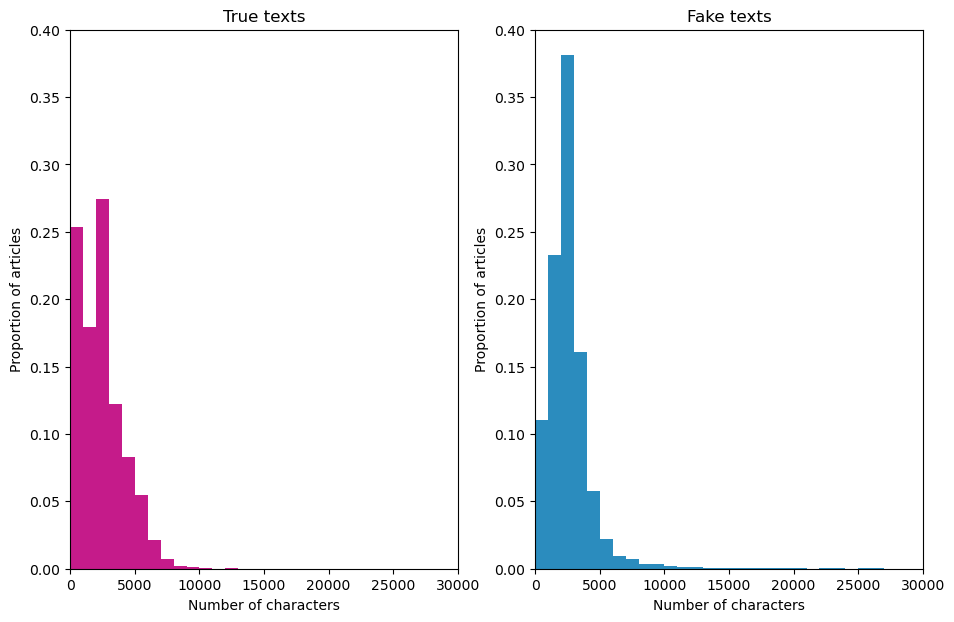

In [35]:
len_cha_true = concat_data[concat_data['label'] == 1]['article'].apply(lambda x: len(x))
len_cha_fake = concat_data[concat_data['label'] == 0]['article'].apply(lambda x: len(x))

norm_weights_true = np.ones(len(len_cha_true))/len(len_cha_true)
norm_weights_fake = np.ones(len(len_cha_fake))/len(len_cha_fake)

bins = [i * 1000 for i in range(0,31)]

fig, (hist1, hist2) = plt.subplots(1,2, figsize = (11,7))
hist1.hist(len_cha_true, bins = bins, weights = norm_weights_true, color = '#c51b8a')
hist1.set_ylim(0, top=0.4)
hist1.set_xlim(0, 30000)
hist1.set_xlabel('Number of characters')
hist1.set_ylabel('Proportion of articles')
hist1.set_title('True texts')

hist2.hist(len_cha_fake, bins = bins, weights = norm_weights_fake, color='#2b8cbe')
hist2.set_ylim(0, top=0.4)
hist2.set_xlim(0, 30000)
hist2.set_xlabel('Number of characters')
hist2.set_ylabel('Proportion of articles')
hist2.set_title('Fake texts');

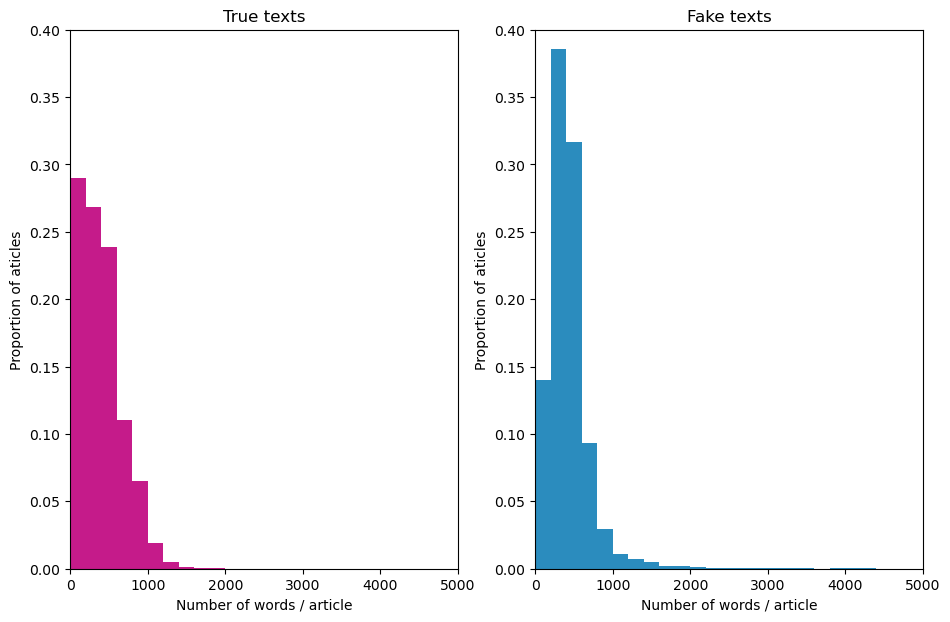

In [36]:
len_w_true = concat_data[concat_data['label'] == 1]['article'].str.split().map(lambda x: len(x))
len_w_fake = concat_data[concat_data['label'] == 0]['article'].str.split().map(lambda x: len(x))

norm_weights_true = np.ones(len(len_w_true))/len(len_w_true)
norm_weights_fake = np.ones(len(len_w_fake))/len(len_w_fake)

bins_ = [i * 200 for i in range(0,26)]

fig, (hist1, hist2) = plt.subplots(1,2, figsize = (11,7))
hist1.hist(len_w_true, bins = bins_, weights = norm_weights_true, color = '#c51b8a')
hist1.set_ylim(0, top=0.4)
hist1.set_xlim(0, 5000)
hist1.set_xlabel('Number of words / article')
hist1.set_ylabel('Proportion of aticles')
hist1.set_title('True texts')
hist2.hist(len_w_fake, bins = bins_, weights = norm_weights_fake, color='#2b8cbe')
hist2.set_ylim(0, top=0.4)
hist2.set_xlim(0, 5000)
hist2.set_xlabel('Number of words / article')
hist2.set_ylabel('Proportion of aticles')
hist2.set_title('Fake texts');

In [37]:
concat_data

,subject,date,article,label
0,politicsNews,2017-12-31,"As U.S. budget fight looms, Republicans flip t...",1
1,politicsNews,2017-12-29,U.S. military to accept transgender recruits o...,1
2,politicsNews,2017-12-31,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,politicsNews,2017-12-30,FBI Russia probe helped by Australian diplomat...,1
4,politicsNews,2017-12-29,Trump wants Postal Service to charge 'much mor...,1
...,...,...,...,...
38635,US_News,2016-01-07,The White House and The Theatrics of ‘Gun Cont...,0
38636,US_News,2016-01-07,Activists or Terrorists? How Media Controls an...,0
38637,US_News,2016-01-06,"BOILER ROOM – No Surrender, No Retreat, Heads ...",0
38638,US_News,2016-01-04,Federal Showdown Looms in Oregon After BLM Abu...,0


<hr>

In [38]:
concat_data.to_csv('concat_dataset.csv', index=False)

<hr>

In [40]:
shuffled_data = concat_data.sample(frac=1, random_state=seed).reset_index(drop=True)
shuffled_data

,subject,date,article,label
0,politics,2015-10-14,Democrats Want GOP To Apologize To Hillary For...,0
1,News,2016-04-21,Colbert Hilariously Humiliates Ted Cruz For L...,0
2,US_News,2016-12-08,Patrick Henningsen LIVE with guest Sean Stone ...,0
3,worldnews,2017-09-11,Gunmen kill four in sectarian attack in Pakis...,1
4,politics,2017-03-10,"HILARIOUS MUST WATCH VIDEO: Hollywood Actor, T...",0
...,...,...,...,...
38635,politicsNews,2017-01-16,Russia ready to rebuild security ties with U.S...,1
38636,worldnews,2017-12-26,Kremlin says ready to mediate North Korea-U.S....,1
38637,US_News,2017-02-10,FAKE NEWS WEEK: How Mainstream Media ‘Fake New...,0
38638,politicsNews,2017-11-01,"Factbox: Belgian mother of two, young New York...",1


<hr> 
<div class="alert alert-block alert-warning"> 
In a previous version of this notebook the whole dataset was used for training.<br>
Due to the fact that at least one team member doesn't use a GPU, it was necessary to scale down the dataset in order to be able to end the training process in a timely manner.<br>
</div>
<hr>

In [81]:
dataset_small_shuffled = shuffled_data.iloc[:5000]

In [82]:
X = dataset_small_shuffled['article']
y = dataset_small_shuffled['label']

In [83]:
# Train-Validation-Test set split into 80:10:10 ratio
train_X, temp_X, train_y, temp_y = train_test_split(X, y, random_state=seed, test_size=0.2, stratify=y)

# Validation-Test split
valid_X, test_X, valid_y, test_y = train_test_split(temp_X, temp_y, random_state=seed, test_size=0.5, stratify=temp_y)

In [84]:
(len(train_X), len(train_y)), (len(valid_X), len(valid_y)), (len(test_X), len(test_y))

((4000, 4000), (500, 500), (500, 500))

In [85]:
train_X

3376     Loser Trump Fails Miserably Again As ‘Monday ...
624     CNBC DEBATE HACK Proves Allegiance To Democrat...
3749    Taiwan the most important issue in Sino-U.S. t...
3648    China says will protect sovereignty from any c...
3565    More than 300 Syrian refugees rescued, arrive ...
                              ...                        
2447    Justice Department, ex-Obama lawyers duel over...
4208    Rights groups say outside monitors needed for ...
1948     Trump Got Caught Doing Something REALLY CREEP...
4679     Racist Joe Arpaio Extorts Money For Re-Electi...
2238    U.S. House panel says Puerto Rico bill in limb...
Name: article, Length: 4000, dtype: object

<hr>

In [86]:
def distribution_data(corpus): 
    """
    Returns number of fake and true news in a given dataset

    Inputs: 
    corpus (array): labels of our dataset
    
    Outputs: 
    distrib (pd.DataFrame): number of true and fake news in the dataset 
    """
    nb_true = corpus.sum()
    nb_false = len(corpus) - nb_true
    distrib = pd.DataFrame(data = {'Number of samples': [nb_true, nb_false], 'Label':['True', 'Fake']})
    return distrib

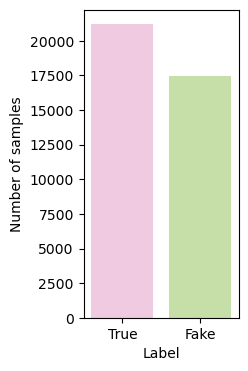

In [87]:
distrib = distribution_data(concat_data['label'])
fig, bar = plt.subplots(figsize = (2,4))
bar = sns.barplot(y='Number of samples', x='Label',data=distrib, palette='PiYG');

<br>
We have slightly more True labeled articles in the distribution than Fake labeled articles. However, this is negligible, especially regarding in training the model.
<br><br>

In [88]:
train_distrib = distribution_data(train_y)
valid_distrib = distribution_data(valid_y)
test_distrib = distribution_data(test_y)

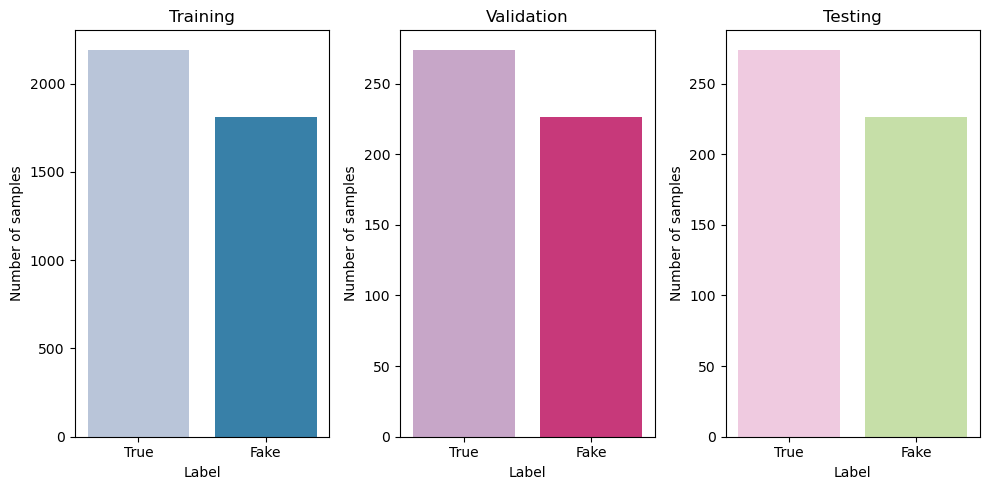

In [89]:
fig, (bar1, bar2, bar3) = plt.subplots(1,3, figsize = (10,5))
sns.barplot(y='Number of samples', x='Label',data=train_distrib, ax = bar1, palette='PuBu')
sns.barplot(y='Number of samples', x='Label',data=valid_distrib, ax = bar2, palette='PuRd')
sns.barplot(y='Number of samples', x='Label',data=test_distrib, ax = bar3, palette='PiYG')
bar1.set_title("Training")
bar2.set_title("Validation")
bar3.set_title("Testing");
plt.tight_layout()

<br>
Training, validation as well as testing are all in the same way balanced. Hence there is no need to adjust them further, at least for this use case.
<br><br>

<hr style="height:15px;border-width:0;color:#CCD7E9;background-color:#CCD7E9">
<br>

In [59]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

num_labels = len(model.config.id2label)

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=num_labels)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifi

In [90]:
train_encodings = tokenizer(
    list(train_X), 
    truncation=True, 
    padding=True, 
    max_length=512, 
    return_tensors="pt"
)

valid_encodings = tokenizer(
    list(valid_X), 
    truncation=True, 
    padding=True, 
    max_length=512, 
    return_tensors="pt"
)

test_encodings = tokenizer(
    list(test_X), 
    truncation=True, 
    padding=True, 
    max_length=512, 
    return_tensors="pt"
)


In [91]:
print("Input IDs:\n", train_encodings['input_ids'][0])
print("\nAttention Mask:\n", train_encodings['attention_mask'][0])


Input IDs:
 tensor([  101, 10916,  8398, 11896, 28616,  6906,  6321,  2153,  2004,  1520,
         6928,  2305,  2374,  1521,  8599,  2061,  2906,  1012, 10166,  1010,
         2009,  1055,  2066,  1037,  2343,  2064,  1056,  2130,  2131,  1037,
        17757,  2183,  4902,  1012,  6221,  8398,  2699,  2000,  4888,  1037,
        17757,  2006,  1996,  5088,  2058,  2304,  7576,  2040,  5454,  2000,
         6181,  2140,  2612,  1997,  3233,  2076,  1996,  2120, 11971,  1999,
         6186,  1997,  5762, 16440,  1998,  2610, 24083,  1012,  8398,  2347,
         1056,  2383,  2151,  1997,  2008,  1010,  2061,  2002,  2165,  2000,
         2010, 10474,  4070,  2044,  4214,  1996,  3060,  1011,  2137,  7576,
         4124,  1997,  7743,  2229,  1010,  2000,  5326,  1037, 17757,  1012,
        11992,  2031,  2196,  2042,  2200,  2204,  2012, 17757,  2015,  4312,
         1012,  1996, 11666,  6431,  9310,  2208,  2956,  5759, 11666,  3954,
         6128,  3557,  2635,  1037,  6181,  1999, 14

In [92]:
tokens = tokenizer.convert_ids_to_tokens(train_encodings['input_ids'][0])
print(tokens)


['[CLS]', 'loser', 'trump', 'fails', 'mis', '##era', '##bly', 'again', 'as', '‘', 'monday', 'night', 'football', '’', 'ratings', 'so', '##ar', '.', 'wow', ',', 'it', 's', 'like', 'a', 'president', 'can', 't', 'even', 'get', 'a', 'boycott', 'going', 'anymore', '.', 'donald', 'trump', 'tried', 'to', 'launch', 'a', 'boycott', 'on', 'the', 'nfl', 'over', 'black', 'athletes', 'who', 'choose', 'to', 'knee', '##l', 'instead', 'of', 'stand', 'during', 'the', 'national', 'anthem', 'in', 'protest', 'of', 'racial', 'inequality', 'and', 'police', 'brutality', '.', 'trump', 'wasn', 't', 'having', 'any', 'of', 'that', ',', 'so', 'he', 'took', 'to', 'his', 'twitter', 'account', 'after', 'calling', 'the', 'african', '-', 'american', 'athletes', 'sons', 'of', 'bitch', '##es', ',', 'to', 'promote', 'a', 'boycott', '.', 'conservatives', 'have', 'never', 'been', 'very', 'good', 'at', 'boycott', '##s', 'anyway', '.', 'the', 'cowboys', 'versus', 'cardinals', 'game', 'featured', 'dallas', 'cowboys', 'owner',

In [56]:
class FakeNewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings  
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


In [93]:
train_dataset = FakeNewsDataset(train_encodings, train_y.tolist())
valid_dataset = FakeNewsDataset(valid_encodings, valid_y.tolist())
test_dataset = FakeNewsDataset(test_encodings, test_y.tolist())


In [108]:
training_args = TrainingArguments(
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    save_steps=500,
    learning_rate=2e-5,
    output_dir='./results',       
    num_train_epochs=3,           
    per_device_train_batch_size=batch_size, 
    per_device_eval_batch_size=batch_size,   
    warmup_steps=500,             
    weight_decay=0.01,  
    load_best_model_at_end=True,
    metric_for_best_model = 'f1',
    logging_dir='./logs',
    logging_steps=10
)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [66]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)
    return {"accuracy": acc, "f1": f1}


In [95]:
class LiveLossPlotCallback(TrainerCallback):
    def __init__(self):
        self.liveloss = PlotLosses()

    def on_train_begin(self, args, state, control, **kwargs):
        self.logs = {}

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            self.logs.update(logs)
            self.liveloss.update(self.logs)
            self.liveloss.send()


In [74]:
live_callback = LiveLossPlotCallback()

In [107]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)


In [109]:
trainer.train(resume_from_checkpoint=True)

Loading model from ./results/checkpoint-500).
***** Running training *****
  Num examples = 4000
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 750
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 2
  Continuing training from global step 500
  Will skip the first 2 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
3,0.000000,0.000764,1.000000,1.000000


***** Running Evaluation *****
  Num examples = 500
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-750
Configuration saved in ./results/checkpoint-750/config.json
Model weights saved in ./results/checkpoint-750/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-750/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-750/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results/checkpoint-750 (score: 1.0).


TrainOutput(global_step=750, training_loss=0.0006562567982279385, metrics={'train_runtime': 1792.7413, 'train_samples_per_second': 6.694, 'train_steps_per_second': 0.418, 'total_flos': 1595967219007488.0, 'train_loss': 0.0006562567982279385, 'epoch': 3.0})

<br>
<hr>
<br>

In [112]:
trainer.evaluate(test_dataset)

***** Running Evaluation *****
  Num examples = 500
  Batch size = 16


{'eval_loss': 2.3473312467103824e-05,
 'eval_accuracy': 1.0,
 'eval_f1': 1.0,
 'eval_runtime': 55.0233,
 'eval_samples_per_second': 9.087,
 'eval_steps_per_second': 0.582,
 'epoch': 3.0}

<br>

<br>

In [123]:
text_test = test_X.iloc[42]
#print(text_test)

In [125]:
inputs = tokenizer(example_text, return_tensors="pt", truncation=True, padding=True)

# start model in evaluation mode
model.eval()

with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits       # we use the raw model outputs aka logits,
    probs = softmax(logits, dim=1) # as well as the probabilities,
    prediction = torch.argmax(probs, dim=1).item() # and check how the model classifies the given articles

labels_map = {0: "True", 1: "Fake"}
print(f"Prediction: {labels_map[prediction]}")
print(f"Probabilities: {probs.numpy()[0]}")

Prediction: True
Probabilities: [9.9996412e-01 3.5920104e-05]


***** Running Prediction *****
  Num examples = 500
  Batch size = 16


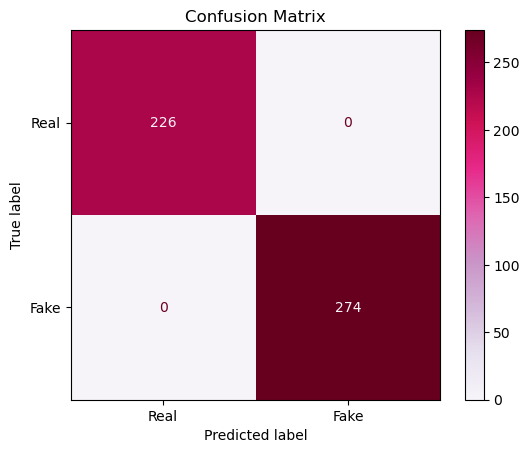


 Classification Report:
               precision    recall  f1-score   support

        Real       1.00      1.00      1.00       226
        Fake       1.00      1.00      1.00       274

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500



In [127]:
test_preds_output = trainer.predict(test_dataset)
test_preds = np.argmax(test_preds_output.predictions, axis=1)
test_labels = test_preds_output.label_ids

cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])
disp.plot(cmap="PuRd")
plt.title("Confusion Matrix")
plt.show()

print("\n Classification Report:\n", classification_report(test_labels, test_preds, target_names=["Real", "Fake"]))


# Interpretation: Confusion Matrix

The confusion matrix demonstrates **perfect classification** performance. All **226 real news articles** were correctly classified as real, and all **274 fake news articles** were correctly classified as fake. There were **no false positives** and **no false negatives**, indicating flawless model behavior on this evaluation batch.


# Interpretation: Classification Report

The evaluation metrics once again reflect **perfect classification performance** on a test set of **500 examples** (226 real, 274 fake). Both precision and recall are **1.00 for all classes**, meaning the model **never misclassified** any sample in this batch.

While this result showcases a **highly effective model**, such consistent perfection could suggest:
- The test data may contain **clear linguistic patterns** or **distinct features** that make classification straightforward.
- Alternatively, this could point toward **potential overfitting**, especially if similar perfect results persist across multiple test batches.

Nonetheless, the current results indicate that the model performs **exceptionally well** under the given evaluation conditions.

<br>

<hr style="height:15px;border-width:0;color:#CCD7E9;background-color:#CCD7E9">
<br>

In [128]:
# Combine articles and labels, randomly draw 5 afterwards
test_pairs = list(zip(test_X.tolist(), test_y.tolist()))
sampled_pairs = random.sample(test_pairs, 5)


In [129]:
model.eval()
for idx, (text, true_label) in enumerate(sampled_pairs):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    probs = softmax(logits, dim=1)
    predicted_class = torch.argmax(probs, dim=1).item()
    confidence = probs[0, predicted_class].item()

    label_map = {0: "Fake", 1: "True"}

    print(f"Sample {idx+1}")
    print(f"Original Text:\n{text[:500]}...")
    print(f"True Label: {label_map[true_label]} — Predicted: {label_map[predicted_class]}")
    print(f"Probabilities: Fake = {probs[0,0]:.4f}, True = {probs[0,1]:.4f} — Confidence: {confidence:.4f}")
    print("-"*100)


Sample 1
Original Text:
PRESIDENT TRUMP’S Powerful First Commencement Speech: “In America We Don’t Worship Government, We Worship God” [VIDEO].President Trump told the graduates that they are  graduating to a totally brilliant future. Trump specifically recognized graduates who have served in the military,  It is truly a testament to this university and to the values that you embrace, that your graduating class includes so many patriots who have served our country in uniform. He also thanked Liberty University Presiden...
True Label: Fake — Predicted: Fake
Probabilities: Fake = 1.0000, True = 0.0000 — Confidence: 1.0000
----------------------------------------------------------------------------------------------------
Sample 2
Original Text:
U.S. general sets two-year goal for driving back Afghan Taliban.WASHINGTON (Reuters) - The top U.S. general in Afghanistan said on Monday he believes he could help Afghan forces drive back the Taliban enough to control at least 80 percent of the c

# Interpretation of Sample Predictions

The model has classified all five samples **perfectly**, with extremely high confidence for each prediction. In all cases, the predicted probability for the correct label was exactly 1.0000, and for the incorrect label, exactly 0.0000.
<br><br>
This level of confidence indicates that the model is **highly certain** in its decisions, at least on this subset of the data. Given that these examples come from a **test set not seen during training**, this suggests that the model has **learned strong and generalizable patterns** from the data.<br><br>

However, such **perfect performance** warrants careful consideration:
- It is possible that the **input text is strongly polarized** (e.g., stylistic cues, source mentions) and therefore **easier to classify**.
- Alternatively, the model may be **overfitting**, especially since earlier training and evaluation phases yielded **perfect accuracy** as well.  


<br>
<hr>
<br>

In [136]:
model.eval()
sample_text = test_X.iloc[0]

inputs = tokenizer(sample_text, return_tensors="pt", truncation=True, padding=True, max_length=512)

with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)

attentions = outputs.attentions
attention_matrix = attentions[-1][0, 0].cpu().numpy()

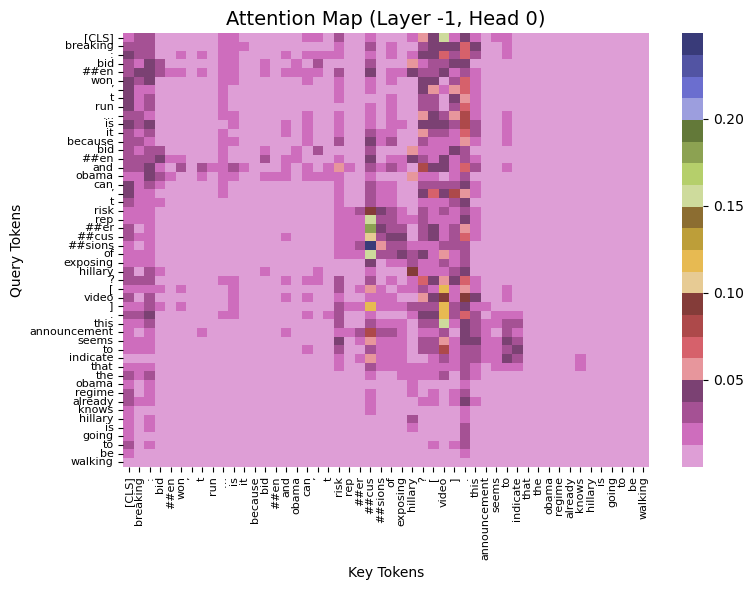

In [150]:
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

num_tokens_to_display = 50
attention_slice = attention_matrix[:num_tokens_to_display, :num_tokens_to_display]
tokens_slice = tokens[:num_tokens_to_display]

plt.figure(figsize=(8, 6))
sns.heatmap(attention_slice, xticklabels=tokens_slice, yticklabels=tokens_slice, cmap='tab20b_r', cbar=True)
plt.title(f"Attention Map (Layer -1, Head 0)", fontsize=14)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.xlabel("Key Tokens")
plt.ylabel("Query Tokens")
plt.tight_layout()
plt.show()

# Interpretation of Attention Map

This heatmap visualizes the **attention scores of a single head (Head 0)** in the **final Transformer layer (Layer -1)** for a selected sample from the test set:

- **Query Tokens** & **Key Tokens**:  
  Each cell represents how much a query token attends to a key token, based on Head 0’s computation alone. Strong attention is shown by warmer colors (yellow/green), while weaker attention is shown in purple shades.

- **Focused Attention**:  
  Compared to the averaged map (all heads, see down below), Head 0 shows a **more sparse and specific focus**. It strongly attends to certain tokens like `exposing`, `hillary`, and `announcement`. This suggests that Head 0 might specialize in attending to **prominent, potentially impactful tokens** in the sentence.
<br>

<hr>

## Head Specialization:  
Attention heads often learn **distinct patterns**. While some focus on local relationships, others capture **global dependencies** or specific linguistic cues. Analyzing individual heads like this gives insight into **what type of information this head processes**.

<br>
<hr>
<br>

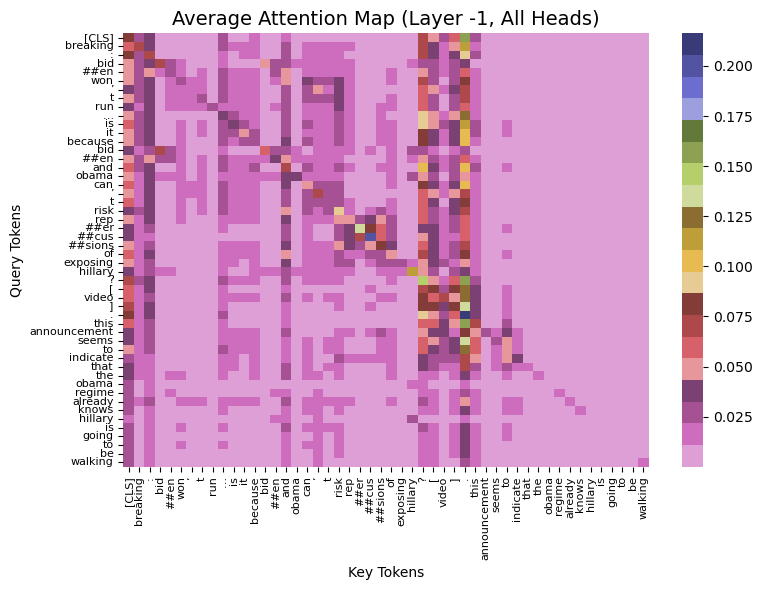

In [151]:
model.eval()
sample_text = test_X.iloc[0]

inputs = tokenizer(sample_text, return_tensors="pt", truncation=True, padding=True, max_length=512)

with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)

attentions = outputs.attentions
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
num_tokens_to_display = 50
tokens_slice = tokens[:num_tokens_to_display]

last_layer_attention = attentions[-1][0]

average_attention = last_layer_attention.mean(dim=0).cpu().numpy()
attention_avg_slice = average_attention[:num_tokens_to_display, :num_tokens_to_display]

plt.figure(figsize=(8, 6))
sns.heatmap(attention_avg_slice, xticklabels=tokens_slice, yticklabels=tokens_slice, cmap='tab20b_r', cbar=True)
plt.title(f"Average Attention Map (Layer -1, All Heads)", fontsize=14)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.xlabel("Key Tokens")
plt.ylabel("Query Tokens")
plt.tight_layout()
plt.show()


# Interpretation of Attention Map (averaged heads)

The heatmap above visualizes the **average attention scores across all attention heads** in the **final Transformer layer** (Layer -1) for a single sample from the test set:

- **Query Tokens** & **Key Tokens**:  
  Each cell represents how much a query token "attends" to a key token. Higher attention values (shown in yellow/green shades) indicate stronger focus or importance placed on that token relationship.

- **[CLS] Token**:  
  The first token is `[CLS]`. You can see it attends (to varying degrees) to other tokens in the sentence.

- **Token-Level Results**:
  - There is **heightened attention** around tokens like `exposing`, `hillary`, `announcement`, and `regime`. These words might be significant in shaping the classification decision (Fake vs. Real).
  - Common **attention alignment patterns** (diagonals and vertical stripes) show self-reference and context integration among semantically related words.

<br>
<hr>

## Explainability:  
Attention maps provide a peek into the "reasoning" of the model. By seeing which tokens influence each other, we can understand which parts of the input text had the greatest impact on the final prediction.

## Balanced View:  
Averaging across all heads reduces noise from individual heads and shows general attention trends. If certain tokens consistently receive strong attention, they likely carry **semantic weight** for the model.



<hr style="height:15px;border-width:0;color:#CCD7E9;background-color:#CCD7E9">

# 2nd Test run with new Test-Batch

The evaluations up to now have been great, almost perfect - and that should be something that always makes you question the model.<br>
For this reason, a second test batch is now being created, which the model will then classify. By doing so, it will hopefully become transparent whether the model has just memorised, whether there has been a data leak that has not yet been noticed - or whether it is actually doing a very good job.<br><br>

In [152]:
dataset_2nd_batch = shuffled_data.iloc[5000:10000].reset_index(drop=True)


In [153]:
X_2nd = dataset_2nd_batch['article']
y_2nd = dataset_2nd_batch['label']


In [162]:
encodings_2nd = tokenizer(list(X_2nd), truncation=True, padding=True, max_length=512, return_tensors='pt')
labels_2nd = torch.tensor(y_2nd.values)

dataset_2nd_dict = {
    'input_ids': encodings_2nd['input_ids'],
    'attention_mask': encodings_2nd['attention_mask'],
    'labels': labels_2nd
}

hf_2nd_dataset = Dataset.from_dict(dataset_2nd_dict)


In [163]:
trainer.evaluate(hf_2nd_dataset)


***** Running Evaluation *****
  Num examples = 5000
  Batch size = 16


{'eval_loss': 0.006953605450689793,
 'eval_accuracy': 0.9992,
 'eval_f1': 0.9992652461425421,
 'eval_runtime': 544.3308,
 'eval_samples_per_second': 9.186,
 'eval_steps_per_second': 0.575,
 'epoch': 3.0}

# Evaluation Summary on a Second Test Set

The model was evaluated on a new batch of **5,000 previously unseen test samples**. Below are the key performance metrics:

- **Evaluation Loss**: `0.00695`  
  → The model's prediction error is very low, indicating highly accurate probability estimates.

- **Accuracy**: `99.92%`  
  → Almost all test samples were correctly classified as either fake or real news.

- **F1 Score**: `0.9993`  
  → This high F1 score confirms excellent balance between precision and recall, meaning the model is not biased towards one class and performs well across both.

- **Evaluation Speed**:  
  → ~9 samples per second, which is solid for the available compute environment.

## Interpretation

The model generalizes extremely well to unseen data. Despite being fine-tuned on a relatively small training subset (5,000 samples), it performs almost flawlessly on a different batch of 5,000 test samples. 

This suggests:
- **Minimal overfitting** – The model has learned meaningful patterns rather than memorizing data.
- **Robust performance** – The near-perfect metrics demonstrate that the model is suitable for practical use.


<hr style="height:15px;border-width:0;color:#CCD7E9;background-color:#CCD7E9">

# Sources:
* [Medium: Fine-Tuning DistilBERT - A Step by Step Practical Guide](https://medium.com/@heyamit10/fine-tuning-distilbert-a-step-by-step-practical-guide-8eda046222b5)

* [Hugging Face - Text Classification Notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/text_classification.ipynb)